Deep Learning

In [65]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

Get the stock from csv

In [66]:
# import all stock prices 
df = pd.read_csv("WIKI-PRICES.csv", index_col = 'date')
# get year 2012-2018 data,the origin data is ordered desc
df = df[:1566]
# reverse order
df = df[::-1]

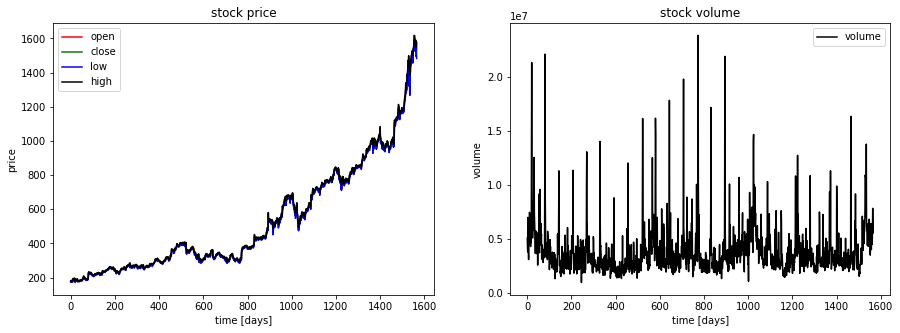

In [67]:
# show the performance of the different column
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(df.volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

Data Engineering

In [82]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# drop columns
df_stock = df.copy()
df_stock.drop(['volume','ex-dividend','split_ratio','adj_open','adj_high','adj_low','adj_volume','ticker','adj_close'],inplace=True,axis=1)
print(df_stock)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

               open      high       low    close
date                                            
2012-01-03   175.89   179.475   175.550   179.03
2012-01-04   179.21   180.500   176.065   177.51
2012-01-05   175.94   178.250   174.050   177.61
2012-01-06   178.07   184.650   177.500   182.61
2012-01-09   182.76   184.370   177.000   178.56
...             ...       ...       ...      ...
2018-03-21  1586.45  1590.000  1563.170  1581.86
2018-03-22  1565.47  1573.850  1542.400  1544.10
2018-03-23  1539.01  1549.020  1495.360  1495.56
2018-03-26  1530.00  1556.990  1499.250  1555.86
2018-03-27  1572.40  1575.960  1482.320  1497.05

[1566 rows x 4 columns]
df_stock.columns.values =  ['open', 'high', 'low', 'close']
x_train.shape =  (1236, 19, 4)
y_train.shape =  (1236, 4)
x_valid.shape =  (155, 19, 4)
y_valid.shape =  (155, 4)
x_test.shape =  (155, 19, 4)
y_test.shape =  (155, 4)


Build RNNCell 

In [83]:
## Basic Cell RNN in tensorflow
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)
# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


Apply MultiRNNCell based on every cell's output performance

In [84]:
def multiLayerCell(layers):
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])    
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)    
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
    loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
    training_op = optimizer.minimize(loss)                                             
    # run graph
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        for iteration in range(int(n_epochs*train_set_size/batch_size)):
            x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
            if iteration % int(5*train_set_size/batch_size) == 0:
                mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
                mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
                print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                    iteration*batch_size/train_set_size, mse_train, mse_valid))

        global y_train_pred, y_valid_pred, y_test_pred
        y_train_pred = sess.run(outputs, feed_dict={X: x_train})
        y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
        y_test_pred = sess.run(outputs, feed_dict={X: x_test})
        
    graph()

In [85]:
def graph():
    ft = 0

    ## show predictions
    plt.figure(figsize=(15, 5));
    plt.subplot(1,2,1);

    plt.plot(y_train[:,ft], color='blue', label='train target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
             color='gray', label='valid target')
    plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], 
                       y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]), y_test[:,ft],
             color='black', label='test target')
    
    plt.plot(y_train_pred[:,ft], color='red',label='train prediction')
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]), y_valid_pred[:,ft],
             color='orange', label='valid prediction')
    plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0], 
                       y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,ft],
             color='green', label='test prediction')

    plt.title('past and future stock prices')
    plt.xlabel('time [days]')
    plt.ylabel('normalized price')
    plt.legend(loc='best');

    plt.subplot(1,2,2);

    plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], 
                       y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]), y_test[:,ft],
             color='black', label='test target')

    plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0], 
                       y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,ft],
             color='green', label='test prediction')

    plt.title('future stock prices')
    plt.xlabel('time [days]')
    plt.ylabel('normalized price')
    plt.legend(loc='best');

    corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
                np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
                np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
    corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
                np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

    print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
        corr_price_development_train, corr_price_development_valid, corr_price_development_test))
        

Build LSTMCell

In [86]:
# use Basic RNN Cell
RNNlayers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
BasicLSTMlayers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
LSTMlayers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                  activation=tf.nn.leaky_relu, use_peepholes = True)
          for layer in range(n_layers)]

RNNCell + MultiRNNCell

0.00 epochs: MSE train/valid = 0.463386/0.863406
4.98 epochs: MSE train/valid = 0.000082/0.000285
9.95 epochs: MSE train/valid = 0.000078/0.000139
14.93 epochs: MSE train/valid = 0.000067/0.000318
19.90 epochs: MSE train/valid = 0.000059/0.000211
24.88 epochs: MSE train/valid = 0.000052/0.000193
29.85 epochs: MSE train/valid = 0.000051/0.000092
34.83 epochs: MSE train/valid = 0.000045/0.000136
39.81 epochs: MSE train/valid = 0.000050/0.000082
44.78 epochs: MSE train/valid = 0.000044/0.000178
49.76 epochs: MSE train/valid = 0.000041/0.000080
54.73 epochs: MSE train/valid = 0.000035/0.000082
59.71 epochs: MSE train/valid = 0.000053/0.000198
64.68 epochs: MSE train/valid = 0.000033/0.000111
69.66 epochs: MSE train/valid = 0.000032/0.000100
74.64 epochs: MSE train/valid = 0.000032/0.000061
79.61 epochs: MSE train/valid = 0.000033/0.000103
84.59 epochs: MSE train/valid = 0.000038/0.000067
89.56 epochs: MSE train/valid = 0.000028/0.000063
94.54 epochs: MSE train/valid = 0.000035/0.000058
99.

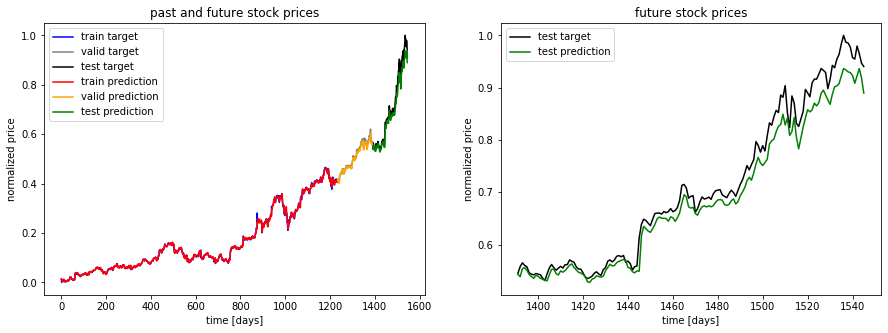

In [87]:
multiLayerCell(RNNlayers)

BasicLSTMCell + MultiRNNCell

In [ ]:
multiLayerCell(BasicLSTMlayers)

0.00 epochs: MSE train/valid = 0.018440/0.126628
4.98 epochs: MSE train/valid = 0.000161/0.000235
9.95 epochs: MSE train/valid = 0.000136/0.000423
14.93 epochs: MSE train/valid = 0.000110/0.000166
19.90 epochs: MSE train/valid = 0.000107/0.000366
24.88 epochs: MSE train/valid = 0.000089/0.000136
29.85 epochs: MSE train/valid = 0.000083/0.000212
34.83 epochs: MSE train/valid = 0.000075/0.000111
39.81 epochs: MSE train/valid = 0.000069/0.000171
44.78 epochs: MSE train/valid = 0.000059/0.000113
49.76 epochs: MSE train/valid = 0.000057/0.000114
54.73 epochs: MSE train/valid = 0.000051/0.000079
59.71 epochs: MSE train/valid = 0.000050/0.000075
64.68 epochs: MSE train/valid = 0.000048/0.000082
69.66 epochs: MSE train/valid = 0.000077/0.000427
74.64 epochs: MSE train/valid = 0.000038/0.000102
79.61 epochs: MSE train/valid = 0.000032/0.000055
84.59 epochs: MSE train/valid = 0.000031/0.000062


LSTMCell + MultiRNNCell

0.00 epochs: MSE train/valid = 0.034776/0.222520
4.98 epochs: MSE train/valid = 0.000202/0.000371
9.95 epochs: MSE train/valid = 0.000147/0.000202
14.93 epochs: MSE train/valid = 0.000112/0.000201
19.90 epochs: MSE train/valid = 0.000150/0.000584
24.88 epochs: MSE train/valid = 0.000085/0.000306
29.85 epochs: MSE train/valid = 0.000074/0.000208
34.83 epochs: MSE train/valid = 0.000065/0.000118
39.81 epochs: MSE train/valid = 0.000097/0.000579
44.78 epochs: MSE train/valid = 0.000057/0.000072
49.76 epochs: MSE train/valid = 0.000052/0.000086
54.73 epochs: MSE train/valid = 0.000046/0.000065
59.71 epochs: MSE train/valid = 0.000039/0.000069
64.68 epochs: MSE train/valid = 0.000041/0.000142
69.66 epochs: MSE train/valid = 0.000047/0.000192
74.64 epochs: MSE train/valid = 0.000041/0.000189
79.61 epochs: MSE train/valid = 0.000031/0.000058
84.59 epochs: MSE train/valid = 0.000032/0.000061
89.56 epochs: MSE train/valid = 0.000061/0.000129
94.54 epochs: MSE train/valid = 0.000030/0.000065
99.

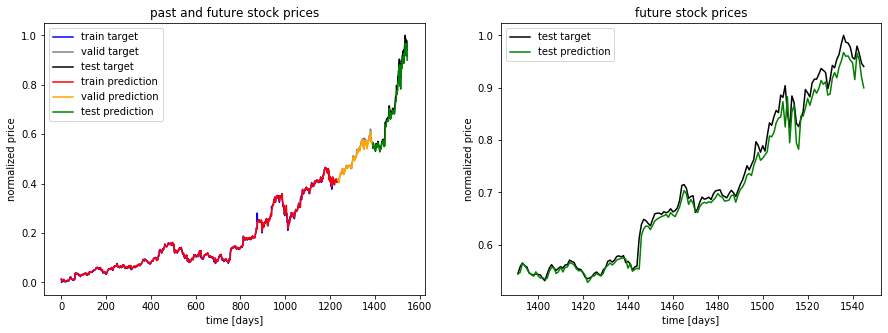

In [44]:
multiLayerCell(LSTMlayers)